# Predicting Norwegian airlines stock closing prices
### Getting and preparing the data

In [26]:
import pandas as pd
from matplotlib import pyplot as plt
data = pd.read_csv('../datasets/NAS.csv', delimiter=',')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-12-18,19.482599,19.596901,19.025499,19.139799,19.139799,4978496.0
1,2003-12-19,19.368299,19.425501,18.282801,18.454201,18.454201,1410901.0
2,2003-12-22,18.739901,18.739901,17.997101,18.054300,18.054300,137047.0
3,2003-12-23,17.997101,17.997101,17.368700,17.425800,17.425800,229418.0
4,2003-12-24,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4248,2020-10-12,0.709000,0.710000,0.650000,0.676800,0.676800,48320475.0
4249,2020-10-13,0.676800,0.676800,0.600000,0.600600,0.600600,47786200.0
4250,2020-10-14,0.601000,0.640000,0.596200,0.626000,0.626000,37534949.0
4251,2020-10-15,0.626000,0.626000,0.585000,0.605000,0.605000,26737615.0


We instantly see that some of the rows contain no values for price and volume, we need to exclude these.
The simplest way of checking if a float is NaN, is to check if it equals itself. If it does not, it isn't a number.

Some minor investigations show that if a number is not available for a datapoint in a row, all of them are NaN. Meaning we only have to check that one of the columns is NaN when removing those from the dataset. Lets arbitrary pick 'Open'

In [27]:
clean_data = data[data.Open == data.Open]
clean_data.reset_index(inplace=True, drop=True)

With linear regression we need all axes to be numbers, date therefore needs to be changed into a more workable datatype. We will change it to be represented as the number of days since the first date entry in the set, 18th december 2003 being the 0'th day. To do that we need a simple function transforming a date string to a daynumber. 

days since genesis : datestring -> days since december 18th 2003

In [28]:
# We need to hard set a variable to the start of our time keeping
genesis = pd.Timestamp(day = 18, month = 12, year = 2003)

# We define a helper lambda function to turn the string into a tuple containing the year, month and day as numbers
date_to_ymd = lambda date : tuple(map(int, date.split('-')))

def days_since_genesis(date) :
    global genesis
    ymd = date_to_ymd(date)
    time = pd.Timestamp(day = ymd[2], month = ymd[1], year = ymd[0])
    return (time - genesis).days

We than need to insert the days field using the function defined above

In [29]:
clean_data['Day'] = clean_data['Date'].apply(days_since_genesis)
clean_data

<ipython-input-29-d92701ebfa6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Day'] = clean_data['Date'].apply(days_since_genesis)


,Date,Open,High,Low,Close,Adj Close,Volume,Day
0,2003-12-18,19.482599,19.596901,19.025499,19.139799,19.139799,4978496.0,0
1,2003-12-19,19.368299,19.425501,18.282801,18.454201,18.454201,1410901.0,1
2,2003-12-22,18.739901,18.739901,17.997101,18.054300,18.054300,137047.0,4
3,2003-12-23,17.997101,17.997101,17.368700,17.425800,17.425800,229418.0,5
4,2003-12-29,17.425800,17.425800,16.854500,17.254400,17.254400,196206.0,11
...,...,...,...,...,...,...,...,...
4213,2020-10-12,0.709000,0.710000,0.650000,0.676800,0.676800,48320475.0,6143
4214,2020-10-13,0.676800,0.676800,0.600000,0.600600,0.600600,47786200.0,6144
4215,2020-10-14,0.601000,0.640000,0.596200,0.626000,0.626000,37534949.0,6145
4216,2020-10-15,0.626000,0.626000,0.585000,0.605000,0.605000,26737615.0,6146


### Fitting

In [30]:
x = clean_data.iloc[:, -1].values.reshape(-1, 1)
y = clean_data.iloc[:, -3].values

In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Linear model
lin_reg = LinearRegression()
lin_reg.fit(x, y)

# 10th degree polynomial model
poly_feat = PolynomialFeatures(degree = 10)
x_trans = poly_feat.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(x_trans, y)

LinearRegression()

### Plotting

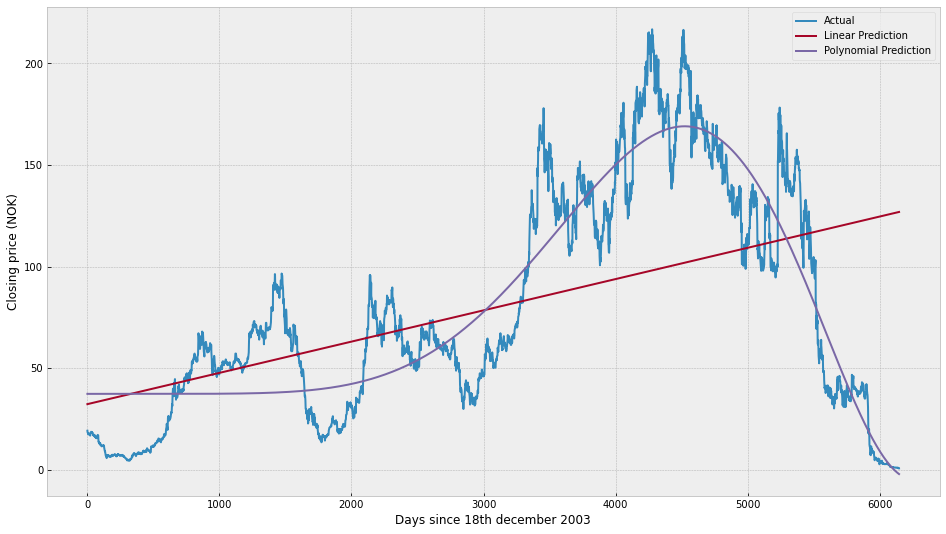

In [46]:
plt.style.use('bmh')
plt.figure(figsize=(16, 9))
plt.xlabel('Days since 18th december 2003')
plt.ylabel('Closing price (NOK)')
plt.plot(clean_data.Day, clean_data.Close)
plt.plot(clean_data.Day, lin_reg.predict(x))
plt.plot(clean_data.Day, pol_reg.predict(x_trans))
plt.legend(['Actual', 'Linear Prediction', 'Polynomial Prediction'])
plt.show()

### Precictions on arbitrary date

In [39]:
# Functions that takes a date as a parameter and predicts number of passengers on the average bus trip that day
# Date in the format 'yyyy-mm-dd'
def predict(date) :
    day = days_since_genesis(date)
    return pol_reg.predict(poly_feat.fit_transform(([[day]])))[0]

To test the prediction lets pick three dates, one in the past, one in the dataset and one in the future

In [40]:
print(predict('2003-11-11'))
print(predict('2007-08-04'))
print(predict('2020-12-24'))

37.29095388270557
37.701782833795775
-4.3851357359479834


### Error in prediction

The inbuilt method score will give us a measure of accuracy

In [64]:
poly_score = pol_reg.score(x_trans, y)
lin_score = lin_reg.score(x, y)
print('Linear regression accuracy     {:.3}%'.format(lin_score * 100))
print('Polynomial regression accuracy {:.3}%'.format(poly_score * 100))

Linear regression accuracy     24.5
Polynomial regression accuracy 81.8


Meaning an error of

In [63]:
print('Linear regression error     {:.3}%'.format(1 - lin_score))
print('Polynomial regerssion error {:.3}%'.format(1 - poly_score))

Linear regression error     0.755
Polynomial regerssion error 0.182
